In [1]:
# The code was removed by DSX for sharing.

,Material,Usura_mat_g,Durezza_Disco,Comprex_LP,Comprex_LR,Grindo_LP,Grindo_LR,CodPinza_0,CodPinza_1,CodPinza_3,...,PistoneCpx_54,PistoneCpx_57,Inerzia_45.0,Inerzia_51.0,Inerzia_65.0,Inerzia_72.5,Raggio_medio_104.0,Raggio_medio_113.0,Raggio_medio_117.7,Raggio_medio_118.0
0,3,7.3,228,187,180,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1,4,10.4,195,229,236,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
2,3,6.9,179,194,191,676,718,0,1,0,...,1,0,0,0,1,0,1,0,0,0
3,3,7.7,226,161,179,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,4,10.0,183,232,226,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1


NB: in the whole code we have to replace cross_entropy with accuracy !

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create reusable functions

In [13]:
# Given a set of model parameters (learning rate, regularization penalty coefficient), find the optimal parameters with cross validation

def cross_validation(set_of_learning_rates, set_of_regs, X_t, y_t):
    n_folds = 3
    skf = StratifiedKFold(y_t, n_folds=n_folds) # Get train-validation set stratified (keeps the same distribution) splitter
    set_of_params = [(x,y) for x in set_of_learning_rates for y in set_of_regs]
    
    print "Number of folds: " + str(n_folds)
    print "Number of parameters combinations: " + str(len(set_of_params))
    
    cross_entropy = np.zeros(len(set_of_params))

    # Repeat for every train-validate combination 
    for cv_train_index, cv_val_index in skf:
        X_cv_train, X_cv_val = X_t[cv_train_index], X_t[cv_val_index]
        y_cv_train, y_cv_val = y_t[cv_train_index], y_t[cv_val_index]

        for param_idx, param in enumerate(set_of_params):
            print "Combination " + str(param_idx) + ": Parameters: " +  str(param)
            print "Combination " + str(param_idx) + ": Train model" 
            W, b, W2, b2 = train_nn(X_cv_train, y_cv_train, param[0], param[1]) # Train
            print "Combination " + str(param_idx) + ": Predict" 
            _, cross_entropy_cv = predict(X_cv_val, y_cv_val, W, b, W2, b2) # Predict for valiation set
            cross_entropy[param_idx] = cross_entropy[param_idx] + cross_entropy_cv # Calculate error (cross entropy)

    cross_entropy = cross_entropy / n_folds # Calculate average error
    

    print "BEST LEARNING RATE = ", set_of_params[np.argmax(cross_entropy)][1]
    print "BEST REG (CROSS-ENTROPY) = ", set_of_params[np.argmax(cross_entropy)][0]
    
    # Plot the results
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Y = map(lambda x: x[0], set_of_params)
    X = map(lambda x: x[1], set_of_params)
    for i in np.arange(len(X)):
        ax.scatter(X[i], Y[i], cross_entropy[i], color = "r")
        ax.plot_surface(X[i], Y[i], cross_entropy[i], color = "b")
    ax.set_xlabel('alpha')
    ax.set_ylabel('L1')
    ax.set_zlabel('R2')
    plt.show()
    
    return set_of_params[np.argmax(cross_entropy)]

In [4]:
# Classify the X input set using 2-layer network with weight and bias parameters for each layer as parameters (W,b and W2, b2)
def predict(X, y, W, b, W2, b2):
    hidden_layer = np.maximum(0, np.dot(X, W) + b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print ' > Prediction accuracy: %.2f' % (np.mean(predicted_class == y))
    return predicted_class, np.mean(predicted_class == y)

In [5]:
# Train the 2-layer network (X_i input features, y_i input labels)
def train_nn(X_i, y_i, learning_rate, reg):
    
    # Parameter initilization
    W = 0.01 * np.random.randn(D,h)
    b = np.zeros((1,h))
    W2 = 0.01 * np.random.randn(h,K)
    b2 = np.zeros((1,K))
    num_examples = X_i.shape[0]
    
    # Epochs
    for i in xrange(50000):

        hidden_layer = np.maximum(0, np.dot(X_i, W) + b)
        scores = np.dot(hidden_layer, W2) + b2 # Logits

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # Turn logits into probabilities

        corect_logprobs = -np.log(probs[range(num_examples),y_i])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2) # Apply regularization
        loss = data_loss + reg_loss # Calculate loss

        # Backpropagation
        dscores = probs
        dscores[range(num_examples),y_i] -= 1
        dscores /= num_examples

        
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        dhidden = np.dot(dscores, W2.T)

        dhidden[hidden_layer <= 0] = 0

        dW = np.dot(X_i.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        dW2 += reg * W2
        dW += reg * W

        # Update parameters
        W += - learning_rate * dW
        b += - learning_rate * db
        W2 += - learning_rate * dW2
        b2 += - learning_rate * db2

    print "iteration %d: loss %f" % (i, loss)
    return W, b, W2, b2

In [6]:
# Calculate the final score for the model using test set
def score_model(X_tr, Y_tr, X_ts, Y_ts, best_learning_rate, best_reg):
    print "BEST LEARNING RATE (CROSS-ENTROPY) = " + str(best_learning_rate)
    print "BEST REG (CROSS-ENTROPY) = " + str(best_reg)

    # Train the model with the best hyperparameters
    W, b, W2, b2 = train_nn(X_tr, Y_tr, best_learning_rate, best_reg) 
    
    # Predict test data
    predicted_class, cross_entropy_test = predict(X_ts, Y_ts, W, b, W2, b2)
    print "CROSS-ENTROPY = " +str(cross_entropy_test)
    print predicted_class
    print Y_ts
    
    # Plot the results
    plt.scatter(np.arange(0, len(Y_ts)), predicted_class, color='b')
    plt.scatter(np.arange(0, len(Y_ts)), Y_ts, color='r')

    lines = []
    ax = plt.axes()

    for i in range(predicted_class.shape[0]):
        lines.append([(i, predicted_class[i]), (i, Y_ts[i])])

    lc = mc.LineCollection(lines, colors="g", linewidths=1)

    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.grid(True)

    plt.show()

# Perfom the evaluation over the data

In [7]:
# Prepare the dataset & configurations for the network
X = df_data_1.drop("Material",1).values
D =  X.shape[1]
num_examples = X.shape[0]
K = len(df_data_1["Material"].unique())
y = df_data_1["Material"].values

step_size = 1e-04
reg = 1e-03

h = 30 # size of hidden layer

In [8]:
print "Input data shape: ",X.shape
print "Target data shape",y.shape
print "Number of features: ",D
print "Number of classes: ",K
print "Number of examples: ",num_examples
print "Number of hidden units: ",h

Input data shape:  (651, 49)
Target data shape (651,)
Number of features:  49
Number of classes:  5
Number of examples:  651
Number of hidden units:  30


In [9]:
# Split the train and test datasets

from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(y, 1, test_size=.15, random_state=0)

for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print "Train shape: " + str(X_train.shape)
    print "Test shape: " + str(X_test.shape)

Train shape: (554, 49)
Test shape: (97, 49)


Cross validaton
Number of folds: 3
Number of parameters combinations: 4
Combination 0: Parameters: (0.01, 0.01)
Combination 0: Train model
iteration 49999: loss 0.552327
Combination 0: Predict
 > Prediction accuracy: 0.70
Combination 1: Parameters: (0.01, 0.02)
Combination 1: Train model
iteration 49999: loss 0.563649
Combination 1: Predict
 > Prediction accuracy: 0.75
Combination 2: Parameters: (0.02, 0.01)
Combination 2: Train model
iteration 49999: loss 1.501722
Combination 2: Predict
 > Prediction accuracy: 0.35
Combination 3: Parameters: (0.02, 0.02)
Combination 3: Train model
iteration 49999: loss 1.501722
Combination 3: Predict
 > Prediction accuracy: 0.35
Combination 0: Parameters: (0.01, 0.01)
Combination 0: Train model
iteration 49999: loss 1.506124
Combination 0: Predict
 > Prediction accuracy: 0.36
Combination 1: Parameters: (0.01, 0.02)
Combination 1: Train model
iteration 49999: loss 0.760513
Combination 1: Predict
 > Prediction accuracy: 0.64
Combination 2: Parameters: (

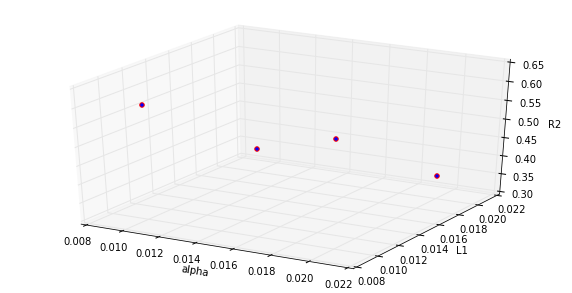

In [10]:
# Evaluate the different parameters for the model & plot

set_of_learning_rates = np.arange(1e-2, 3e-2, step=1e-2)
set_of_regs = np.arange(1e-2, 3e-2, step=1e-2)

best_params = cross_validation(set_of_learning_rates, set_of_regs, X_train, y_train)

best_learning_rate = best_params[1]
best_reg = best_params[0]

Score model
BEST LEARNING RATE (CROSS-ENTROPY) = 0.01
BEST REG (CROSS-ENTROPY) = 0.01
Train the model with the best hyperparameters
iteration 49999: loss 0.575395
Predict test data
 > Prediction accuracy: 0.70
CROSS-ENTROPY = 0.701030927835
[2 0 0 3 0 0 0 3 3 0 3 2 0 0 2 2 0 0 0 3 0 0 3 3 2 2 0 2 3 3 4 3 2 3 2 2 3
 3 0 3 2 0 0 0 2 4 3 0 2 3 3 0 0 2 2 3 0 3 3 0 3 3 2 0 2 4 3 2 2 0 3 2 2 0
 2 4 3 3 0 0 3 0 4 2 0 2 2 2 3 4 2 0 3 0 0 2 3]
[2 0 0 3 0 0 3 3 3 0 3 1 0 0 1 2 3 0 0 4 0 0 3 3 1 2 3 1 4 3 4 4 2 3 1 2 3
 3 3 3 2 0 0 0 1 4 3 0 1 3 3 3 0 2 2 0 3 3 3 3 3 3 1 0 1 4 3 2 1 0 3 2 2 0
 1 4 4 3 0 3 4 0 4 2 0 2 1 2 3 3 2 0 3 3 3 2 3]


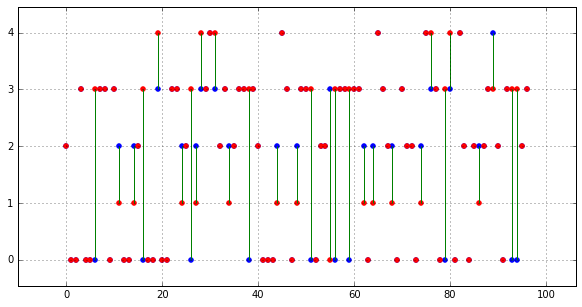

In [14]:
# Calculate the final score for the model
score_model(X_train, y_train, X_test, y_test, best_learning_rate, best_reg)

 # 70% of samples correctly classified